# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import scikitplot as skplt

from pathlib import Path
from matplotlib import pyplot as plt

from scipy import stats
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm

# 1. Data Preparation

In [2]:
# load data
path = str(Path.cwd().parents[0] / "data" / "processed")
path = path + '/' + 'df_eda.csv'

df = pd.read_csv(path)

In [3]:
# return variables to original values

# response
# driving_license
# vehicle_damage
# previously_insured

for i in df.columns:

    if (i == 'response') | (i == 'driving_license') | (i == 'vehicle_damage') | (i == 'previously_insured'):
        df[i] = df[i].apply(lambda x: 1 if x == 'Yes' else 0)
    
    else:
        pass

In [4]:
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11,152,1,New,1,0,23367.0,249,0
1,13,Female,41,15,14,1,Average,0,1,31409.0,221,0
2,18,Female,25,35,152,1,New,0,1,46622.0,299,0
3,31,Female,26,8,160,1,New,0,0,2630.0,136,0
4,39,Male,45,8,124,1,Average,1,0,42297.0,264,0


In [5]:
# simulates production environment

X = df.drop('response', axis = 1) # real data does not contain response
y = df['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size = 0.20) # spit dataset between train and test

df = pd.concat([x_train, y_train], axis = 1)

## Standardization
Only attributes with Normal distribution.

In [6]:
# annual_premium (we will not remove outliers now)

ss = pp.StandardScaler()

df['annual_premium'] = ss.fit_transform(df[['annual_premium']].values) # encoder receives an array

## Rescaling

In [7]:
# saves scaler to the same variable which will be used in the test
mms_age = pp.MinMaxScaler() 
mms_vintage = pp.MinMaxScaler()

# age
df['age'] = mms_age.fit_transform(df[['age']].values)

# vintage
df['vintage'] = mms_vintage.fit_transform(df[['vintage']].values)

## Encoding
Only categorical attributes which we want to mantain its nature (eg. binary, ordinal)

In [8]:
# gender
target_encode_gender = df.groupby('gender')['response'].mean()
df.loc[:,'gender'] = df['gender'].map(target_encode_gender)

# region_code - Frequency Encoding | Target Encoding (we choose this) | Weigthed Target Encoding
target_encode_region_code = df.groupby('region_code')['response'].mean()
df.loc[:,'region_code'] = df['region_code'].map(target_encode_region_code) # replace all values within policy_sales_channel column with encoded values

# vehicle_age - One Hot Encoding (we choose this) | Order Encoding
df = pd.get_dummies(df, prefix = 'vehicle_age', columns = ['vehicle_age'])

# policy_sales_channel - Target Encoding | Frequency Encoding (we choose this)
# Frequency Encoding gives more weight to more frequent values of the categorical attribute
fe_policy_sales_channel = df.groupby('policy_sales_channel').size() / len(df)
df.loc[:,'policy_sales_channel'] = df['policy_sales_channel'].map(fe_policy_sales_channel) # replace all values within policy_sales_channel column with encoded values


## Validation Preparation

In [9]:
# applies same training encoders to testing (validation, val) data

# gender
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map(target_encode_gender)

# age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_val.loc[:, 'vehicle_age'] = pd.get_dummies(x_val, prefix = 'vehicle_age', columns = ['vehicle_age'])

# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# fillna
x_val = x_val.fillna(0)

# 2. Feature Selection

## 2.1. Features Importancy

In [10]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators = 250, random_state = 0, n_jobs = -2) # n_jobs will not use all cores

# # data preparation
# x_train_n = df.drop(['id', 'response'], axis = 1)
# y_train_n = y_train.values
# forest.fit(x_train_n, y_train_n)

In [11]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
# indices = np.argsort(importances)[::-1]

# # Print feature ranking
# print('Feature Ranking:')
# data = pd.DataFrame()
# for i, j in zip(x_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index = [0])
#     data = pd.concat([data, aux], axis = 0)

# print(data.sort_values('importance', ascending = False))

# # Plot the impurity-based feature importances of the forest
# plt.figure()
# plt.title('Feature Importances')
# plt.bar(range(x_train_n.shape[1]), importances[indices], color = 'r', yerr = std[indices], align = 'center')
# plt.xticks(range(x_train_n.shape[1]), indices)
# plt.xlim([-1, x_train_n.shape[1]])
# plt.show()


# 3. Machine Learning

In [12]:
# arbitrary selection
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [13]:
# using only the selected features to train and test (validation) the model
x_train = df[cols_selected]
x_val = x_val[cols_selected]

## 3.1. KNN

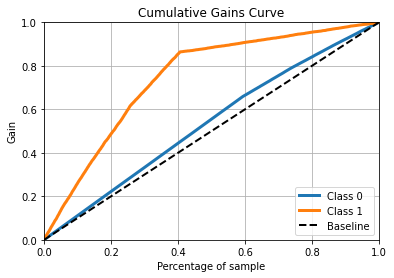

In [51]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors = 7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

# what this chart tell?
# if i make the offer to 40% of the ordered list, i will find ~85% of interested people (with 07 neighbors)
# this means the KNN model left interested people on the end of the list
# more KNN Neighbors = i will find more interested people

## 3.2. Linear Regression

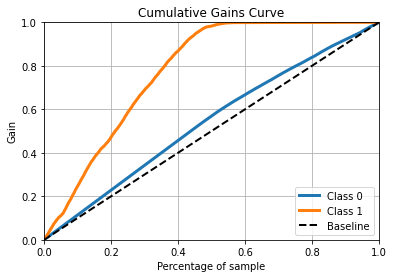

In [17]:
# model definition
lr_model = lm.LogisticRegression(random_state = 42)

# model training
lr_model.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_lr = lr_model.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

In [ ]:
# HOMEWORK: test with random forest and xgboost and compares cumulative gains curves.
# you want to find 100% of interested people with least percentage of sample.
# Test with PCA Encoding.

# HOMEWORK: find a Ranking Metric to summarize Cumulative Gains Curve chart.

## 3.3. Extra Trees

In [ ]:
# model definition
et = en.ExtraTreesClassifier(n_estimators = 1000, n_jobs = -2, random_state = 42)

# model training
et.fit(x_train, y_train)

# model prediction - Generalizing Power
yhat_et = et.predict_proba(x_val)

skplt.metrics.plot_cumulative_gain(y_val, yhat_et);

# 4. Model Performance

In [88]:
# copy data
df_perf = x_val.copy()#.reset_index()
df_perf['response'] = y_val.copy()
df_perf.reset_index(inplace = True)
df_perf.rename(columns = {'index':'id'}, inplace = True)

# propensity score - from KNN Model
df_perf['score'] = yhat_knn[:,1].tolist() # get all propensity score values of response = 1 then converts to list

# sort list by propensity score value
df_perf = df_perf.sort_values('score', ascending = False)

# compute precision at k


In [89]:
df_perf['response'].unique()

array([0, 1])

In [90]:
df_perf.head(30)

,id,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured,response,score
31717,176333,0.750865,0.732862,0.323077,0.185663,1,0.209917,0,0,1.000000
4372,163623,0.951557,0.453171,0.230769,0.089014,1,0.193793,0,0,1.000000
42057,156569,0.605536,0.643386,0.138462,0.185663,1,0.028020,0,1,1.000000
60550,18386,0.089965,-0.538146,0.369231,0.127464,1,0.209917,0,0,1.000000
22551,312044,0.698962,0.991883,0.430769,0.185663,1,0.209917,0,0,1.000000
64139,250013,0.453287,0.439119,0.138462,0.096640,1,0.193793,0,1,1.000000
10485,56948,0.103806,0.152983,0.200000,0.133540,1,0.193793,0,0,1.000000
42127,379544,0.567474,0.204137,0.292308,0.185663,1,0.209917,0,0,1.000000
14672,327682,0.771626,0.254884,0.184615,0.185663,1,0.026026,0,1,1.000000
70147,221601,0.069204,-0.052271,0.353846,0.121441,1,0.193793,0,0,0.857143


#